In [1]:
# Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For Text processing
import string
import re
import warnings
warnings.filterwarnings('ignore')

# Install and import nltk and upprade if necessary libraries
%pip install nltk
import nltk
%pip install --upgrade pandas
%pip install openpyxl --upgrade


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# After reading the xsl file we find 4 missing values in the column 'Content'
df = pd.read_excel('df_complete_cleansing.xlsx')
df.head()
df.isna().sum()
  

SenderID             0
ReceiverID           0
ActionType           0
NegoOutcome          0
Content              4
Content_Length       0
Sentence_Count       0
Word_Count_nltk      0
NegoOutcomeLabel     0
Sentiment            0
SentimentCategory    0
dtype: int64

In [3]:
# Calculate the cumulative length of each exchanged message
df['Negotiation_Content_Length_sum'] = df.groupby(['SenderID', 'ReceiverID'])['Content_Length'].cumsum()

# Display df
#df

In [4]:
# Initialize a new column for negotiation length
df['Negotiation_Length'] = 0

# Function to calculate negotiation length
def calculate_negotiation_length(group):
    length = 0
    for i, row in group.iterrows():
        length += 1
        df.at[i, 'Negotiation_Length'] = length
        if row['ActionType'] in ['FinalAccept', 'FinalReject']:
            break

# Apply the function to each group of SenderID and ReceiverID
df.groupby(['SenderID', 'ReceiverID']).apply(calculate_negotiation_length)

# Display the DataFrame for verification focus on cell 6-7
#df.head(30)

""


SenderID 70 sent two counteroffers one after another is this an error in the system or is it possible since in the end he has a total of 8 sent messages and receiver 69 only 6. We will check if the sender id and receiver id follow the strict order of being a b a b instead of a a b a b a b b a. Cell 6 - 7 example.

In [5]:
import pandas as pd

# Count rows with missing values
na_rows = df[df['Content'].isna()]
print(na_rows)

      SenderID  ReceiverID    ActionType  NegoOutcome Content  Content_Length  \
552       2057        2058   FinalAccept  FinalAccept     NaN              29   
857       3457        3458  Counteroffer  FinalAccept     NaN               1   
1247       103         104         Offer  FinalAccept     NaN               8   
1404       133         134   FinalReject  FinalReject     NaN               1   

      Sentence_Count  Word_Count_nltk  NegoOutcomeLabel  Sentiment  \
552                1                5                 1        1.0   
857                1                1                 1        0.0   
1247               1                3                 1        0.5   
1404               1                1                 0        0.0   

     SentimentCategory  Negotiation_Content_Length_sum  Negotiation_Length  
552           Positive                            1367                   3  
857            Neutral                               1                   1  
1247        

In [6]:
import pandas as pd

# Remove rows with NaN in Content
df = df.dropna(subset=['Content'])

# Remove rows with empty strings or insignificant content in Content
def is_insignificant_content(content):
    return content.strip() == '' or content.strip() == '.' or len(content.split()) == 1

df = df[~df['Content'].apply(is_insignificant_content)]

# Validate Content Length (optional, if Content_Length column is used)
df['Content_Length'] = df['Content'].apply(len)

### **<span style="color: orange;">Term Frequency-Inverse Document Frequency (TF-IDF)</span>**
TF-IDF is an extension of the Bag of Words model that aims to address some of its limitations. It assigns a weight to each word based on its frequency in a document (term frequency) and its rarity across the entire corpus (inverse document frequency). TF-IDF helps to highlight important words in a document while down-weighting common words that appear in many documents.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
# Define the vectorizer with enhanced parameters
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),               # Use unigrams and bigrams
    stop_words='english',             # Remove common English stop words
    max_features=5000,                # Limit to the top 5000 features
    min_df=0.01,                      # Ignore terms appearing in less than 1% of documents
    max_df=0.90,                      # Ignore terms appearing in more than 90% of documents
    sublinear_tf=True,                # Apply log scaling to term frequencies
    use_idf=True,                     # Use IDF weighting
    decode_error='ignore',            # Handle decoding errors
    norm='l2',                        # Normalize term frequencies
)

In [9]:
tfidf_vectorizer.fit(df['Content'])
tfidf_message_vector = tfidf_vectorizer.transform(df['Content'])

In [10]:
tfidf_message_vector.shape

(2324, 1442)

In [11]:
message_tfidf_array = tfidf_message_vector.toarray()
df_tfidf = pd.DataFrame(data = message_tfidf_array, columns=tfidf_vectorizer.get_feature_names_out())
print(df_tfidf)

          able  able attend  abroad  absent  absolutely    accept  \
0     0.055605          0.0     0.0     0.0         0.0  0.000000   
1     0.000000          0.0     0.0     0.0         0.0  0.000000   
2     0.000000          0.0     0.0     0.0         0.0  0.000000   
3     0.000000          0.0     0.0     0.0         0.0  0.000000   
4     0.000000          0.0     0.0     0.0         0.0  0.000000   
...        ...          ...     ...     ...         ...       ...   
2319  0.000000          0.0     0.0     0.0         0.0  0.000000   
2320  0.000000          0.0     0.0     0.0         0.0  0.055601   
2321  0.000000          0.0     0.0     0.0         0.0  0.000000   
2322  0.000000          0.0     0.0     0.0         0.0  0.158554   
2323  0.000000          0.0     0.0     0.0         0.0  0.225339   

      accept additional  accept offer  accept proposal  acceptable  ...  \
0                   0.0           0.0              0.0    0.000000  ...   
1                   0

# **<span style="color: orange;">XGBoost Model</span>**

In [ ]:
# Import necessary libraries
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
import xgboost as xgb

In [ ]:
# Define features and target
X_xgb = df_tfidf.values  # Features from CountVectorizer
y_xgb = df['NegoOutcomeLabel'].values  # Target

In [ ]:
# Split data into training and testing sets
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.33, random_state=42, stratify=y_xgb)

In [ ]:
# Initial XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train_xgb, y_train_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predict and evaluate the model
y_pred_test = xgb_model.predict(X_test_xgb)


In [ ]:
# Print AUC score
print("ROC AUC: {:.4f}".format(roc_auc_score(y_test_xgb, y_pred_test)))

ROC AUC: 0.6303


In [ ]:
# Classification report
print(classification_report(y_test_xgb, y_pred_test))

              precision    recall  f1-score   support

           0       0.60      0.37      0.46       239
           1       0.76      0.89      0.82       528

    accuracy                           0.73       767
   macro avg       0.68      0.63      0.64       767
weighted avg       0.71      0.73      0.71       767



In [ ]:
# Hyperparameter tuning with GridSearchCV
parameters = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]

}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=parameters, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_xgb, y_train_xgb)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [ ]:
# Use the best parameters
best_params = grid_search.best_params_
best_xgb_model = xgb.XGBClassifier(**best_params, random_state=42,use_label_encoder=False, eval_metric='logloss')
best_xgb_model.fit(X_train_xgb, y_train_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predict and evaluate the optimized model
y_pred_best = best_xgb_model.predict(X_test_xgb)

In [ ]:
# Print accurcacy score
print("Accuracy: {:.4f}".format(accuracy_score(y_test_xgb, y_pred_best)))

Accuracy: 0.7288


In [ ]:
# Print the best hyperparameters
print("\nBest Hyperparameters:")
print(grid_search.best_params_)


Best Hyperparameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


In [ ]:
# Evaluate the Model
print("XGBoostEvaluation:")
print(f"Training Accuracy: {xgb_model.score(X_train_xgb, y_train_xgb):.4f}")
print(f"Test Accuracy: {xgb_model.score(X_test_xgb, y_test_xgb):.4f}")

XGBoostEvaluation:
Training Accuracy: 0.9852
Test Accuracy: 0.7275


In [ ]:
# Generate and directly print the classification report
print(classification_report(y_test_xgb, y_pred_best))

              precision    recall  f1-score   support

           0       0.65      0.28      0.39       239
           1       0.74      0.93      0.83       528

    accuracy                           0.73       767
   macro avg       0.70      0.60      0.61       767
weighted avg       0.71      0.73      0.69       767



In [ ]:
# Save results to a DataFrame for later comparison
results_xgb = pd.DataFrame({
    'Model': ['XGBoost', 'XGBoost (Optimized)'],
    'Accuracy': [accuracy_score(y_test_xgb, y_pred_test), accuracy_score(y_test_xgb, y_pred_best)],
    'ROC AUC': [roc_auc_score(y_test_xgb, y_pred_test), roc_auc_score(y_test_xgb, y_pred_best)],
    'F1 Score': [f1_score(y_test_xgb, y_pred_test, average='weighted'), f1_score(y_test_xgb, y_pred_best, average='weighted')]
})

# **<span style="color: orange;">Naive Bayes</span>**

In [ ]:
# Define features and target
X_nb = df_tfidf.values  # Features from CountVectorizer
y_nb = df['NegoOutcomeLabel'].values  # Target

In [ ]:
# Split data into training and testing sets
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X_nb, y_nb, test_size=0.33, random_state=42, stratify=y_nb)

In [ ]:
from sklearn.naive_bayes import GaussianNB
# Initial GaussianNB model
gnb = GaussianNB()
gnb.fit(X_train_nb, y_train_nb)

GaussianNB()

In [ ]:
y_pred_test = gnb.predict(X_test_nb)

In [ ]:
# Step 5: Evaluate the Model
print("Naive Bayes Model Evaluation:")
print(f"Training Accuracy: {gnb.score(X_train_nb, y_train_nb):.4f}")
print(f"Test Accuracy: {gnb.score(X_test_nb, y_test_nb):.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test_nb, y_pred_test))

Naive Bayes Model Evaluation:


Training Accuracy: 0.8356
Test Accuracy: 0.6962
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.50      0.51       239
           1       0.78      0.79      0.78       528

    accuracy                           0.70       767
   macro avg       0.64      0.64      0.64       767
weighted avg       0.69      0.70      0.69       767



In [ ]:
# Cross-Validation
cv_scores = cross_val_score(gnb, X_train_nb, y_train_nb, cv=10, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

Cross-Validation Accuracy Scores: [0.71153846 0.69871795 0.76923077 0.73076923 0.69871795 0.67948718
 0.66666667 0.70967742 0.67096774 0.62580645]
Mean CV Accuracy: 0.6962


In [ ]:
# Hyperparameter Tuning
params = {'var_smoothing': np.logspace(0, -9, num=100)}
grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=params, scoring='accuracy', cv=10, verbose=1)
grid_search.fit(X_train_nb, y_train_nb)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


GridSearchCV(cv=10, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.3...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy', verbose=1)

In [ ]:
# Best Parameters and Score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# Retrain with Best Parameters
gnb_best = GaussianNB(var_smoothing=grid_search.best_params_['var_smoothing'])
gnb_best.fit(X_train_nb, y_train_nb)
y_pred_best = gnb_best.predict(X_test_nb)

Best Hyperparameters: {'var_smoothing': 0.0015199110829529332}
Best CV Score: 0.7147890818858561


In [ ]:
# Evaluate the Model
print("Naive Bayes Model Evaluation:")
print(f"Training Accuracy: {gnb.score(X_train_nb, y_train_nb):.4f}")
print(f"Test Accuracy: {gnb.score(X_test_nb, y_test_nb):.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test_nb, y_pred_best))

Naive Bayes Model Evaluation:
Training Accuracy: 0.8356
Test Accuracy: 0.6962
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.44      0.48       239
           1       0.77      0.83      0.80       528

    accuracy                           0.71       767
   macro avg       0.65      0.63      0.64       767
weighted avg       0.69      0.71      0.70       767



In [ ]:
# Save results to a DataFrame for later comparison
results_nb = pd.DataFrame({
    'Model': ['Naive Bayes', 'Naive Bayes (Optimized)'],
    'Accuracy': [accuracy_score(y_test_nb, y_pred_test), accuracy_score(y_test_nb, y_pred_best)],
    'ROC AUC': [roc_auc_score(y_test_nb, y_pred_test), roc_auc_score(y_test_nb, y_pred_best)],
    'F1 Score': [f1_score(y_test_nb, y_pred_test, average='weighted'), f1_score(y_test_nb, y_pred_best, average='weighted')]
})

# **<span style="color: orange;">Random Forest</span>**

In [ ]:
# Define features and target
X_rf = df_tfidf.values  # Features from CountVectorizer
y_rf = df['NegoOutcomeLabel'].values  # Target

In [ ]:
# Split data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.33, random_state=42, stratify=y_rf)

In [ ]:
X_train_rf.shape, X_test_rf.shape

((1557, 1463), (767, 1463))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Train the model
rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Train the model
rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Predict on test data
y_pred_rf = rf.predict(X_test_rf)

# Evaluate the model
print("Random Forest Classifier")
print("Accuracy:", accuracy_score(y_test_rf, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test_rf, y_pred_rf))
print("Classification Report:\n", classification_report(y_test_rf, y_pred_rf))

Random Forest Classifier
Accuracy: 0.741851368970013
Confusion Matrix:
 [[ 64 175]
 [ 23 505]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.27      0.39       239
           1       0.74      0.96      0.84       528

    accuracy                           0.74       767
   macro avg       0.74      0.61      0.61       767
weighted avg       0.74      0.74      0.70       767



In [ ]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(criterion='gini', random_state=42, n_estimators=100, n_jobs=-1, verbose=1)
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=params, scoring='accuracy', cv=10, verbose=1)
grid_search.fit(X_train_rf, y_train_rf)

# warnings can be ignored

Fitting 10 folds for each of 27 candidates, totalling 270 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [ ]:
rf_best = RandomForestClassifier(**grid_search.best_params_, random_state=42)
rf_best.fit(X_train_rf, y_train_rf)

RandomForestClassifier(max_depth=15, n_estimators=300, random_state=42)

In [ ]:
rfc_best_pred = rf_best.predict(X_test_rf)

In [ ]:
# Save results to a DataFrame for later comparison
results_rf = pd.DataFrame({
    'Model': ['Random Forest', 'Ramdom Forest (Optimized)'],
    'Accuracy': [accuracy_score(y_test_rf, y_pred_rf),accuracy_score(y_test_rf, rfc_best_pred)],
    'ROC AUC': [roc_auc_score(y_test_rf, y_pred_rf), roc_auc_score(y_test_rf, rfc_best_pred)],
    'F1 Score': [f1_score(y_test_rf, y_pred_rf, average='weighted'), f1_score(y_test_rf, rfc_best_pred, average='weighted')]
})


# **<span style="color: orange;">Logistic Regression</span>**

In [ ]:
import numpy as np
import nltk
from nltk.data import find
import gensim
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [ ]:
# Define features and target
X_log = df_tfidf.values  # Features from CountVectorizer
y_log = df['NegoOutcomeLabel'].values  # Target

In [ ]:
# Split data into training and testing sets
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.33, random_state=42, stratify=y_log)

In [ ]:
# Initialize and train Logistic Regression model
logreg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
logreg.fit(X_train_log, y_train_log)


LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [ ]:
# Predict on test set
y_pred_test = logreg.predict(X_test_log)

Logistic Regression Test Accuracy: 0.7001
Logistic Regression Training Accuracy: 0.9801


In [ ]:
# Check if there's overfitting or underfitting by comparing the training and test accuracy scores
print(f"Training-set accuracy score: {logreg.score(X_train_log, y_train_log):.4f}")
print(f"Test-set accuracy score: {logreg.score(X_test_log, y_test_log):.4f}")

Training-set accuracy score: 0.9801
Test-set accuracy score: 0.7001


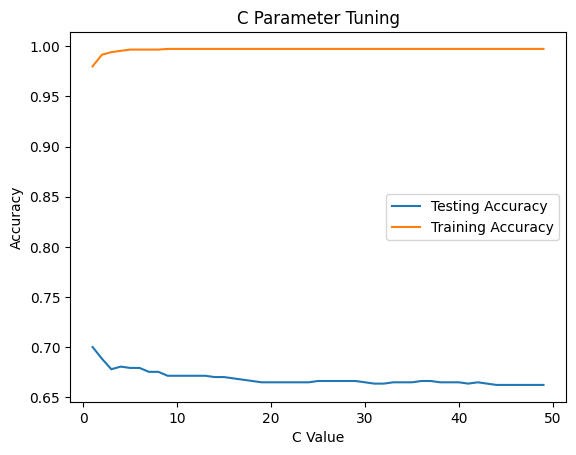

In [ ]:
# Tuning the C parameter
section = np.arange(1, 50)
test_accuracy = np.empty(len(section))
train_accuracy = np.empty(len(section))
for i, k in enumerate(section): 
    logreg_tune = LogisticRegression(C=k, solver='liblinear', random_state=42)
    logreg_tune.fit(X_train_log, y_train_log)
    test_accuracy[i] = logreg_tune.score(X_test_log, y_test_log)
    train_accuracy[i] = logreg_tune.score(X_train_log, y_train_log)

# Plot the tuning results
plt.title('C Parameter Tuning')
plt.plot(section, test_accuracy, label='Testing Accuracy')
plt.plot(section, train_accuracy, label='Training Accuracy')
plt.legend()
plt.xlabel('C Value')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Logistic Regression with tuned C=5 (chosen from grid search)
logreg_best = LogisticRegression(C=5, solver='liblinear', random_state=42)
logreg_best.fit(X_train_log, y_train_log)


LogisticRegression(C=5, random_state=42, solver='liblinear')

In [ ]:
# Predict with the best model
y_pred_best = logreg_best.predict(X_test_log)

In [ ]:
# ROC AUC Score
roc_auc = roc_auc_score(y_test_log, y_pred_best)
print(f"ROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 0.6239


In [ ]:
# Hyperparameter tuning using GridSearchCV
parameters = [{'penalty': ['l1', 'l2']}, {'C': [1, 5, 10, 100, 250, 1000]}]
grid_search = GridSearchCV(estimator=logreg_best, param_grid=parameters, cv=10, scoring='accuracy')
grid_search.fit(X_train_log, y_train_log)

GridSearchCV(cv=10,
             estimator=LogisticRegression(C=5, random_state=42,
                                          solver='liblinear'),
             param_grid=[{'penalty': ['l1', 'l2']},
                         {'C': [1, 5, 10, 100, 250, 1000]}],
             scoring='accuracy')

In [ ]:
# Print out the best score and best parameters
print(f"Best GridSearchCV Score: {grid_search.best_score_:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")


Best GridSearchCV Score: 0.7200
Best Parameters: {'C': 1}


In [ ]:
# Best Model from GridSearchCV
best_logreg = grid_search.best_estimator_

In [ ]:

# Predict with the best model
y_pred_best = best_logreg.predict(X_test_log)

In [ ]:
# Evaluate performance
best_acc = accuracy_score(y_test_log, y_pred_best)
print(f"Best Model Test Accuracy: {best_acc:.4f}")

Best Model Test Accuracy: 0.7001


In [ ]:
# Precision, Recall, and F1 Score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test_log, y_pred_best)
recall = recall_score(y_test_log, y_pred_best)
f1 = f1_score(y_test_log, y_pred_best, average='weighted')

print(f"Best Model Precision: {precision:.4f}")
print(f"Best Model Recall: {recall:.4f}")
print(f"Best Model F1 Score: {f1:.4f}")

Best Model Precision: 0.7680
Best Model Recall: 0.8087
Best Model F1 Score: 0.6947


In [ ]:
# Save results to a DataFrame for later comparison
results_logreg = pd.DataFrame({
    'Model': ['Logistic Regression', 'Logistic Regression (Optimized)'],
    'Accuracy': [accuracy_score(y_test_log, y_pred_test), accuracy_score(y_test_log, y_pred_best)],
    'ROC AUC': [roc_auc_score(y_test_log, y_pred_test), roc_auc_score(y_test_log, y_pred_best)],
    'F1 Score': [f1_score(y_test_log, y_pred_test, average='weighted'), f1_score(y_test_log, y_pred_best, average='weighted')]
})


# **<span style="color: orange;">Support Vector Machine</span>**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import pandas as pd

In [ ]:
# Define features and target
X_svm = df_tfidf.values  # Features from CountVectorizer
y_svm = df['NegoOutcomeLabel'].values  # Target

In [ ]:
# Split data into training and testing sets
X_train_svm , X_test_svm , y_train_svm , y_test_svm  = train_test_split(X_svm , y_svm , test_size=0.33, random_state=42, stratify=y_svm )

In [ ]:
# Fit base SVM model
svm = SVC(kernel='linear', C=1, gamma=0.1)
svm.fit(X_train_svm , y_train_svm)

SVC(C=1, gamma=0.1, kernel='linear')

In [ ]:
# Predict with base SVM model
y_pred_svm = svm.predict(X_test_svm)

In [ ]:
svm.support_vectors_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Check if model overfits
print("Train set Accuracy: ", svm.score(X_train_svm, y_train_svm))
print("Test set Accuracy: ", svm.score(X_test_svm, y_test_svm))

Train set Accuracy:  0.993577392421323
Test set Accuracy:  0.6558018252933507


In [ ]:
# How good is the ROC based prediction?
from sklearn.metrics import roc_auc_score

ROC_AUC = roc_auc_score(y_test_svm, y_pred_svm)

print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.6137


In [ ]:
# What are the best parameters for the model?
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=SVC(), param_grid={'C': [1, 10], 'gamma': [0.1, 0.9], 'kernel': ['rbf', 'linear']})

grid_search.fit(X_train_svm, y_train_svm)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'gamma': [0.1, 0.9],
                         'kernel': ['rbf', 'linear']})

In [ ]:
# print out best possible parameters
print('Best parameters:', grid_search.best_params_)

# print out best score
print('Gridsearch CV best score:', grid_search.best_score_)

Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Gridsearch CV best score: 0.6910771704180064


In [ ]:
#Modeling with the optimal parameters
best_svm = SVC(kernel='rbf', gamma=0.9, C=10)

#it classifier to training data
best_svm.fit(X_train_svm, y_train_svm)

#make new predictions
y1_pred = best_svm.predict(X_test_svm)

In [ ]:
# Print results

print('train accuracy before:', svm.score(X_train_svm, y_train_svm))
print('test accuracy before:', svm.score(X_test_svm, y_test_svm))

print('train accuracy after:', best_svm.score(X_train_svm, y_train_svm))
print('test accuracy after:', best_svm.score(X_test_svm, y_test_svm))

train accuracy before: 0.993577392421323
test accuracy before: 0.6558018252933507
train accuracy after: 0.9980732177263969
test accuracy after: 0.6883963494132985


In [ ]:
# ROC of optimized model in comparison to previous model
ROC_AUC = roc_auc_score(y_test_svm, y_pred_svm)

print('ROC AUC before: {:.4f}'.format(ROC_AUC))

ROC_AUC1 = roc_auc_score(y_test_svm, y1_pred)

print('ROC AUC after: {:.4f}'.format(ROC_AUC1))

ROC AUC before: 0.6137
ROC AUC after: 0.5000


In [ ]:
from sklearn.model_selection import cross_val_score

C_range = list(range(1, 26))
acc_score = []

# Cross validation with 10 folds
for c in C_range:
    svc = SVC(kernel= 'poly',C=c)
    scores = cross_val_score(svc, X_svm, y_svm, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())   
print(acc_score)

In [ ]:
# visualize optimisation iteration
plt.figure(figsize=(10,6))
plt.plot(C_range,acc_score,color = 'blue',linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. C Value')
plt.xlabel('Value of C for SVC')
plt.ylabel('Cross-Validated Accuracy')

In [ ]:
# Compute the cross-val scores for the model with default setting and our optimzed model

#Cross validation for model with default setting
scores = cross_val_score(svm, X= X_train_svm, y = y_train_svm, cv=10, n_jobs=1)
print("Cross-validation scores for default model: {}".format(scores))

#Cross validation for model with optimized setting
scores1 = cross_val_score(best_svm, X= X_train_svm, y = y_train_svm, cv=10, n_jobs=1)
print("Cross-validation scores for optimized model: {}".format(scores1))

In [ ]:
# Print overall f1-score of the whole model
from sklearn.metrics import f1_score
f1_score(y_test_svm, y1_pred, average='weighted')

In [ ]:
# Save results to a DataFrame for later comparison
results_svm = pd.DataFrame({
    'Model': ['SVM', 'SVM (Optimized)'],
    'Accuracy': [accuracy_score(y_test_svm, y_pred_svm), accuracy_score(y_test_svm, y1_pred)],
    'ROC AUC': [roc_auc_score(y_test_svm, y_pred_svm), roc_auc_score(y_test_svm, y1_pred)],
    'F1 Score': [f1_score(y_test_svm, y_pred_svm, average='weighted'), f1_score(y_test_svm, y1_pred, average='weighted')]
})


# **<span style="color: orange;">Model Comparison</span>**

In [ ]:
# Concatenate all model results into a single DataFrame
results_combined = pd.concat([results_xgb, results_nb, results_rf, results_svm, results_logreg], ignore_index=True)

In [ ]:
results_combined

,Model,Accuracy,ROC AUC,F1 Score
0,XGBoost,0.727510,0.630321,0.706282
1,XGBoost (Optimized),0.728814,0.604931,0.689450
2,Naive Bayes,0.696219,0.641946,0.694962
3,Naive Bayes (Optimized),0.707953,0.634438,0.698990
4,Random Forest,0.741851,0.612111,0.697911
5,Ramdom Forest (Optimized),0.713168,0.544329,0.622845
6,SVM,0.655802,0.613735,0.660336
7,SVM (Optimized),0.688396,0.500000,0.561349
8,Logistic Regression,0.700130,0.634482,0.694674
9,Logistic Regression (Optimized),0.700130,0.634482,0.694674


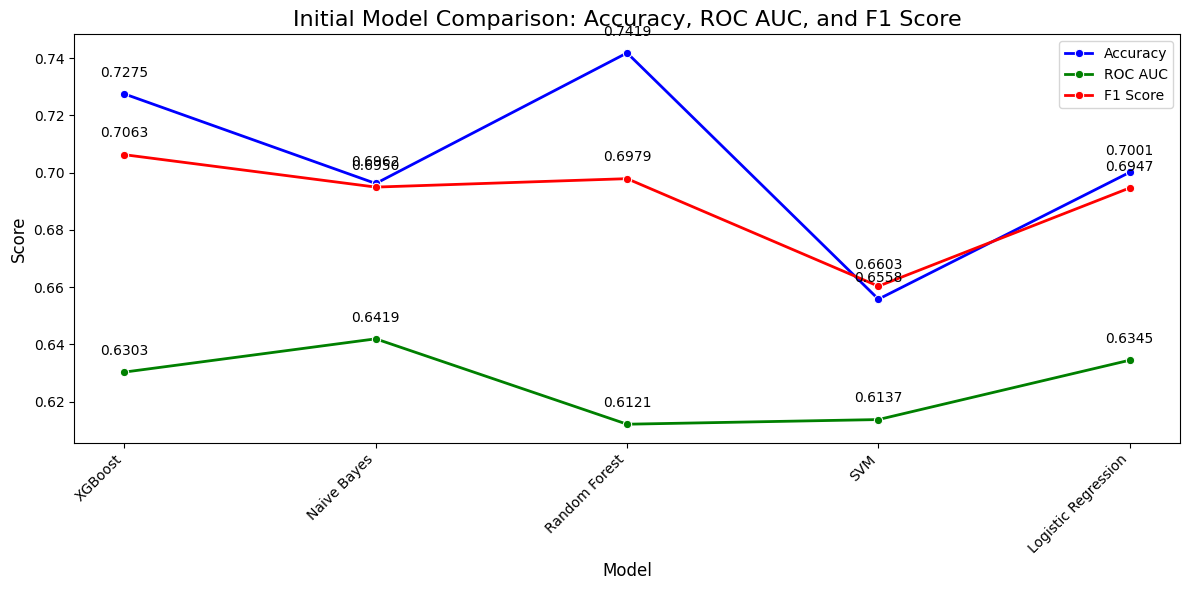

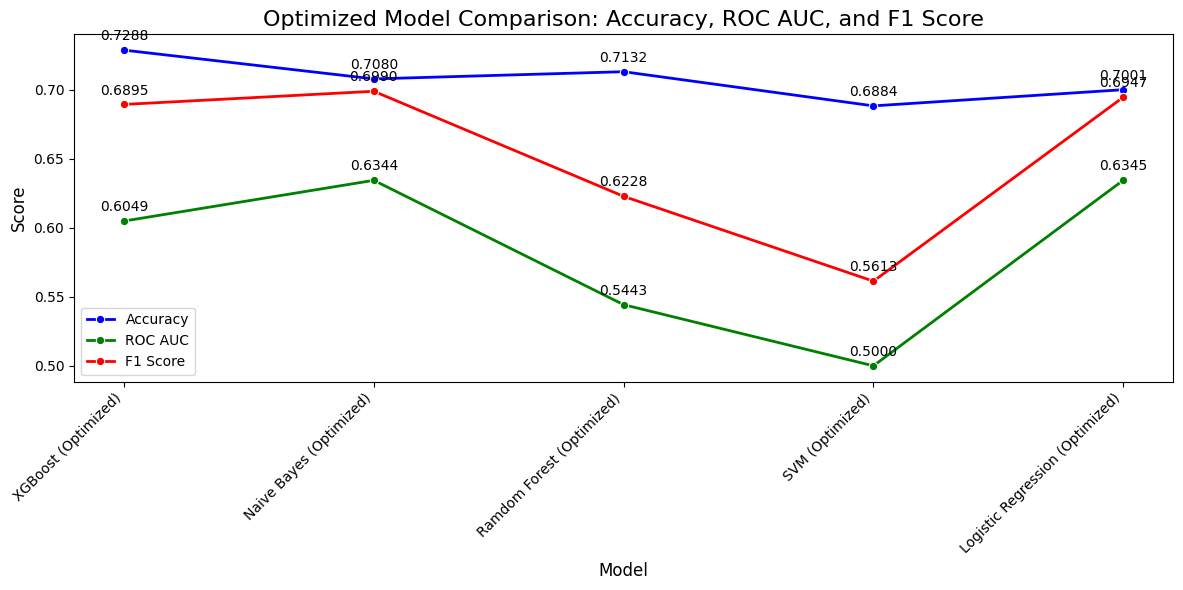

In [ ]:
# Filter for initial models that do not contain parentheses
initial_models = results_combined[~results_combined['Model'].str.contains(r'\(', case=False)]
# Filter for optimized models
optimized_models = results_combined[results_combined['Model'].str.contains('Optimized', case=False)]

# Plot for Initial Models
plt.figure(figsize=(12, 6))

# Plot Accuracy, ROC AUC, and F1 Score for initial models
sns.lineplot(x='Model', y='Accuracy', data=initial_models, label='Accuracy', marker='o', color='blue', lw=2)
sns.lineplot(x='Model', y='ROC AUC', data=initial_models, label='ROC AUC', marker='o', color='green', lw=2)
sns.lineplot(x='Model', y='F1 Score', data=initial_models, label='F1 Score', marker='o', color='red', lw=2)

# Add titles and labels
plt.title('Initial Model Comparison: Accuracy, ROC AUC, and F1 Score', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value labels for each point
for i in range(len(initial_models)):
    plt.text(i, initial_models['Accuracy'].iloc[i] + 0.005, f'{initial_models["Accuracy"].iloc[i]:.4f}', ha='center', va='bottom')
    plt.text(i, initial_models['ROC AUC'].iloc[i] + 0.005, f'{initial_models["ROC AUC"].iloc[i]:.4f}', ha='center', va='bottom')
    plt.text(i, initial_models['F1 Score'].iloc[i] + 0.005, f'{initial_models["F1 Score"].iloc[i]:.4f}', ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()

# Plot for Optimized Models
plt.figure(figsize=(12, 6))

# Plot Accuracy, ROC AUC, and F1 Score for optimized models
sns.lineplot(x='Model', y='Accuracy', data=optimized_models, label='Accuracy', marker='o', color='blue', lw=2)
sns.lineplot(x='Model', y='ROC AUC', data=optimized_models, label='ROC AUC', marker='o', color='green', lw=2)
sns.lineplot(x='Model', y='F1 Score', data=optimized_models, label='F1 Score', marker='o', color='red', lw=2)

# Add titles and labels
plt.title('Optimized Model Comparison: Accuracy, ROC AUC, and F1 Score', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value labels for each point
for i in range(len(optimized_models)):
    plt.text(i, optimized_models['Accuracy'].iloc[i] + 0.005, f'{optimized_models["Accuracy"].iloc[i]:.4f}', ha='center', va='bottom')
    plt.text(i, optimized_models['ROC AUC'].iloc[i] + 0.005, f'{optimized_models["ROC AUC"].iloc[i]:.4f}', ha='center', va='bottom')
    plt.text(i, optimized_models['F1 Score'].iloc[i] + 0.005, f'{optimized_models["F1 Score"].iloc[i]:.4f}', ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()


In [ ]:
#pip install plotly

  Obtaining dependency information for plotly from https://files.pythonhosted.org/packages/e5/ae/580600f441f6fc05218bd6c9d5794f4aef072a7d9093b291f1c50a9db8bc/plotly-5.24.1-py3-none-any.whl.metadata
  Obtaining dependency information for tenacity>=6.2.0 from https://files.pythonhosted.org/packages/b6/cb/b86984bed139586d01532a587464b5805f12e397594f19f931c4c2fbfa61/tenacity-9.0.0-py3-none-any.whl.metadata
  Using cached tenacity-9.0.0-py3-none-any.whl.metadata (1.2 kB)
   ---------------------------------------- 0.0/19.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/19.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/19.1 MB 1.1 MB/s eta 0:00:18
   ---------------------------------------- 0.2/19.1 MB 2.0 MB/s eta 0:00:10
    --------------------------------------- 0.3/19.1 MB 2.1 MB/s eta 0:00:09
    --------------------------------------- 0.5/19.1 MB 2.3 MB/s eta 0:00:08
   - -------------------------------------- 0.6/19.1 MB 2.4 MB/s eta 0:00:08
   -


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import plotly.express as px

# Filter for initial models that do not contain parentheses
initial_models = results_combined[~results_combined['Model'].str.contains(r'\(', case=False)]

# Filter for optimized models
optimized_models = results_combined[results_combined['Model'].str.contains('Optimized', case=False)]

# Create a new DataFrame that includes only Accuracy and labels for Base and Optimized models
base_data = initial_models[['Model', 'Accuracy']]
base_data['Type'] = 'Base'

optimized_data = optimized_models[['Model', 'Accuracy']]
optimized_data['Type'] = 'Optimized'

# Combine both DataFrames
combined_data = pd.concat([base_data, optimized_data])

# Create a pivot table for the stacked bar plot
pivot_data = combined_data.pivot_table(index='Model', columns='Type', values='Accuracy', aggfunc='max').reset_index()

# Melt the pivot table to long format for Plotly
melted_data = pivot_data.melt(id_vars='Model', value_vars=['Base', 'Optimized'], var_name='Type', value_name='Accuracy')

# Create the interactive stacked bar plot
fig = px.bar(melted_data, x='Model', y='Accuracy', color='Type', barmode='stack',
             title='Model Comparison: Accuracy (Base vs Optimized)',
             labels={'Accuracy': 'Accuracy Score', 'Model': 'Model'},
             height=600, width=1200)

# Update layout for better readability
fig.update_layout(title_font_size=24, xaxis_title_font_size=20, yaxis_title_font_size=20,
                  legend_title_font_size=16, xaxis_tickangle=-45)

# Show the plot
fig.show()